In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter


MERraw = pd.read_csv('stockraw.csv', index_col = 'Date')
MERraw = MERraw.iloc[::-1]
MERraw.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
10/7/2020,272.0,272.0,273.0,269.2,247.13K,0.00%
10/8/2020,276.6,272.6,276.6,270.0,177.56K,1.69%
10/9/2020,273.6,276.6,276.6,272.6,346.90K,-1.08%
10/12/2020,281.0,274.0,284.6,273.8,364.56K,2.70%
10/13/2020,284.0,281.0,284.0,279.6,128.06K,1.07%


In [2]:
# Get closing price as feature
close = MERraw['Price']
values = close.values

training_data_amt = math.ceil(len(values)*0.8)   

In [3]:
# Normalize stock data
scaler = MinMaxScaler(feature_range=(0,1))
# Reshape normalized data to 2D array
scaled = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled[0: training_data_amt, :]
len(train_data)

403

In [4]:
# Get feature and label data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [5]:
# Change feature and label data into array then reshape

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
# Define Model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh',))
model.add(layers.LSTM(100, return_sequences=False, activation='tanh'))
model.add(layers.Dense(16))
model.add(layers.Dense(4))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 122,889
Trainable params: 122,889
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Compile and Fitting 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=8, epochs=50)

Epoch 1/50
43/43 [==============================] - 5s 32ms/step - loss: 0.0299
Epoch 2/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0052
Epoch 3/50
43/43 [==============================] - 1s 33ms/step - loss: 0.0044
Epoch 4/50
43/43 [==============================] - 1s 33ms/step - loss: 0.0038
Epoch 5/50
43/43 [==============================] - 2s 37ms/step - loss: 0.0040
Epoch 6/50
43/43 [==============================] - 1s 33ms/step - loss: 0.0043
Epoch 7/50
43/43 [==============================] - 1s 33ms/step - loss: 0.0039
Epoch 8/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0037
Epoch 9/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0037
Epoch 10/50
43/43 [==============================] - 1s 33ms/step - loss: 0.0039
Epoch 11/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0041
Epoch 12/50
43/43 [==============================] - 1s 33ms/step - loss: 0.0034
Epoch 13/50
43/43 [==================

In [8]:
# Get test data
test_data = scaled[training_data_amt-60: , : ]
x_test = []
y_test = values[training_data_amt:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
# Get Predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(((np.mean(predictions - y_test))**2))
print(rmse)

4/4 [==============================] - 1s 16ms/step
2.277640197753909


C:\Users\Andrei\AppData\Local\Temp\ipykernel_8508\730793575.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_history["Predictions"] = predictions


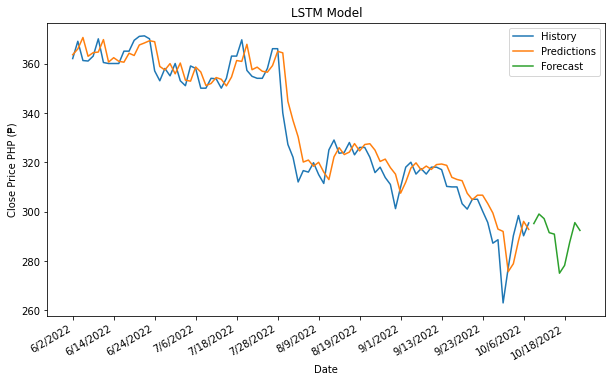

In [14]:
# Visualize 

data = MERraw.filter(['Price'])
test_history = data[training_data_amt:]
test_history["Predictions"] = predictions


df_forecast = test_history["Predictions"]
forecast = df_forecast.tail(10)

df_history = pd.DataFrame(test_history)
df_history = df_history[:-10]


fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price PHP (₱)')
plt.plot(df_history)
plt.plot(forecast)


ax.set_xticks(np.arange(0, len(test_history)+1, 8))
plt.legend(['History', 'Predictions','Forecast'])
plt.gcf().autofmt_xdate()
plt.show()


In [17]:
print(forecast)

Date
10/10/2022    295.154205
10/11/2022    299.015930
10/12/2022    297.148346
10/13/2022    291.459595
10/14/2022    290.862793
10/17/2022    275.031952
10/18/2022    278.190369
10/19/2022    287.571503
10/20/2022    295.531464
10/21/2022    292.367645
Name: Predictions, dtype: float32


In [18]:
output = forecast.to_csv('mercado_mer_forecast.csv')